In [2]:
import os

In [3]:
#connect to drive
from google.colab import drive

drive.mount('/content/drive')

#root_dir is the path to My_Drive folder.
root_dir = "/content/drive/My Drive/"

#data is Stored in MESA 8430 Folder
data_folder = root_dir + "Colab Notebooks"

#change directory to the data folder
os.chdir(data_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

df = pd.read_csv('monthly-car-sales.csv')
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [5]:
for i in range(1, 7):
    df[f'price_lag_{i}'] = df['Sales'].shift(i)

# Drop rows with NaN values created by the lag features
df.dropna(inplace=True)

df.head()

,Month,Sales,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6
6,1960-07,9498,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
7,1960-08,8251,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
8,1960-09,7049,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
9,1960-10,9545,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
10,1960-11,9364,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0


In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define features (X) and target (y)
X = df[[col for col in df.columns if 'price_lag' in col]]
y = df['Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Squared Error (MSE): 7775319.50
Root Mean Squared Error (RMSE): 2788.43
R-squared (R2): 0.49
Mean Absolute Error (MAE): 2292.46


An R-squared value of 0.49 indicates that approximately 49% of the variance in the car sales can be explained by the model using the lag features.

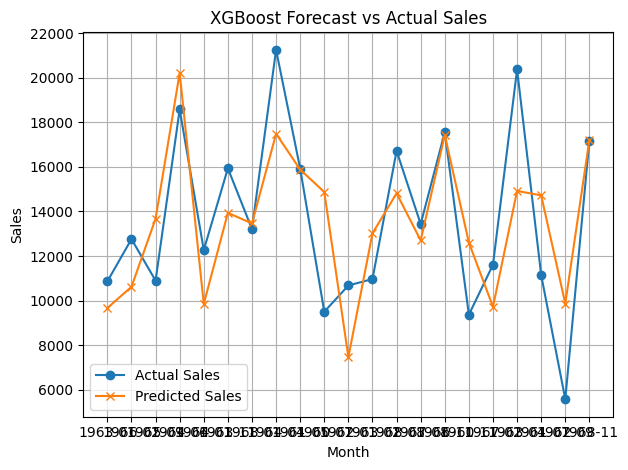

In [8]:
import matplotlib.pyplot as plt

# Plot actual sales
plt.plot(df["Month"].loc[y_test.index], y_test.values,
         label="Actual Sales", marker='o')

# Plot predicted sales
plt.plot(df["Month"].loc[y_test.index], y_pred,
         label="Predicted Sales", marker='x')

plt.title("XGBoost Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os

# Create the 'model' directory if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')

model.get_booster().save_model("model/model.json")

In [ ]:
!pip install fastapi uvicorn xgboost

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import xgboost as xgb
import numpy as np
import os

app = FastAPI()

# Define the input data model for the prediction
class PredictionInput(BaseModel):
    price_lag_1: float
    price_lag_2: float
    price_lag_3: float
    price_lag_4: float
    price_lag_5: float
    price_lag_6: float

# Load the trained XGBoost model
model = xgb.XGBRegressor()
# Ensure the model directory exists
if not os.path.exists('model'):
    os.makedirs('model')
model.load_model("model/model.json")

@app.post("/predict/")
async def predict(data: PredictionInput):
    # Prepare the input data as a numpy array
    input_features = np.array([
        data.price_lag_1,
        data.price_lag_2,
        data.price_lag_3,
        data.price_lag_4,
        data.price_lag_5,
        data.price_lag_6
    ]).reshape(1, -1)

    # Make prediction
    prediction = model.predict(input_features)[0]

    return {"predicted_sales": prediction}

# To run this FastAPI app, you would typically save it as app.py and then run:
# uvicorn app:app --host 0.0.0.0 --port 8000

In [ ]:
import os

# Define the path for the frontend directory
frontend_dir = "frontend"
os.makedirs(frontend_dir, exist_ok=True)

# Define the HTML content for index.html
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Car Sales Predictor</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        .container { max-width: 600px; margin: auto; padding: 20px; border: 1px solid #ccc; border-radius: 8px; }
        label { display: block; margin-bottom: 5px; font-weight: bold; }
        input[type="number"] { width: calc(100% - 22px); padding: 8px; margin-bottom: 10px; border: 1px solid #ddd; border-radius: 4px; }
        button { background-color: #4CAF50; color: white; padding: 10px 15px; border: none; border-radius: 4px; cursor: pointer; font-size: 16px; }
        button:hover { background-color: #45a049; }
        #result { margin-top: 20px; padding: 10px; border: 1px solid #eee; background-color: #f9f9f9; border-radius: 4px; }
    </style>
</head>
<body>
    <div class="container">
        <h1>Car Sales Prediction</h1>
        <form id="predictionForm">
            <label for="price_lag_1">Price Lag 1:</label>
            <input type="number" id="price_lag_1" name="price_lag_1" value="10000" step="0.01" required>

            <label for="price_lag_2">Price Lag 2:</label>
            <input type="number" id="price_lag_2" name="price_lag_2" value="9500" step="0.01" required>

            <label for="price_lag_3">Price Lag 3:</label>
            <input type="number" id="price_lag_3" name="price_lag_3" value="9000" step="0.01" required>

            <label for="price_lag_4">Price Lag 4:</label>
            <input type="number" id="price_lag_4" name="price_lag_4" value="8500" step="0.01" required>

            <label for="price_lag_5">Price Lag 5:</label>
            <input type="number" id="price_lag_5" name="price_lag_5" value="8000" step="0.01" required>

            <label for="price_lag_6">Price Lag 6:</label>
            <input type="number" id="price_lag_6" name="price_lag_6" value="7500" step="0.01" required>

            <button type="submit">Get Prediction</button>
        </form>
        <div id="result">
            <strong>Predicted Sales:</strong> <span id="predictedSales"></span>
        </div>
    </div>

    <script>
        document.getElementById('predictionForm').addEventListener('submit', async function(event) {
            event.preventDefault();

            const data = {
                price_lag_1: parseFloat(document.getElementById('price_lag_1').value),
                price_lag_2: parseFloat(document.getElementById('price_lag_2').value),
                price_lag_3: parseFloat(document.getElementById('price_lag_3').value),
                price_lag_4: parseFloat(document.getElementById('price_lag_4').value),
                price_lag_5: parseFloat(document.getElementById('price_lag_5').value),
                price_lag_6: parseFloat(document.getElementById('price_lag_6').value)
            };

            try {
                const response = await fetch('http://127.0.0.1:8000/predict/', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json'
                    },
                    body: JSON.stringify(data)
                });

                if (!response.ok) {
                    throw new Error(`HTTP error! status: ${response.status}`);
                }

                const result = await response.json();
                document.getElementById('predictedSales').textContent = result.predicted_sales.toFixed(2);
            } catch (error) {
                console.error('Error:', error);
                document.getElementById('predictedSales').textContent = 'Error during prediction.';
            }
        });
    </script>
</body>
</html>
"""

# Write the HTML content to the file
with open(os.path.join(frontend_dir, "index.html"), "w") as f:
    f.write(html_content)

print(f"File 'frontend/index.html' created successfully in '{os.getcwd()}/{frontend_dir}/'")

File 'frontend/index.html' created successfully in '/content/drive/MyDrive/Colab Notebooks/frontend/'
